### Handwriting Analysis using Pattern Recognition (MNIST)

Group 1:
1.	Sai Lahari Pulla 029443724 
2.	Bindu Madhavi Thalapaneni – 029407636 
3.	Vaishnavi Rao – 029412966 
4.	Sai Vani Ginni – 029370560 
5.	Namrata Shownkeen – 028017052
6.	Guru Akhil Tavva - 029365204

#### Source: Keras datasets ( https://keras.io/api/datasets/mnist/ )

#### Description of dataset and our objective:

The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning. It was created by "re-mixing" the samples from NIST's original datasets. 
Furthermore, the black and white images from MNIST were normalized to fit into a 28x28 pixel bounding box and anti-aliased, which introduced grayscale levels.

The MNIST database contains 60,000 training images and 10,000 testing images. Half of the training set and half of the test set were taken from NIST's training dataset, while the other half of the training set and the other half of the test set were taken from NIST's testing dataset

Our goal is to perform handwriting analysis on the MNIST dataset. The input will be a handwritten number (from 0 to 9) and the goal is to output the target number. The goal is also to achieve classification of an image based on its handwritten number. To achieve the same, we have used a simple CNN and performed optimizer evaluation. With the best params, we have predicted the value of an input image of a handwritten number.

#### Importing all libraries

In [2]:
from keras.models import Sequential
import tensorflow as tf
import numpy as np
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.datasets import mnist
import seaborn as sns
import pandas as pd
import io
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import exposure
from scipy.stats import mode, norm
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from scipy.linalg import eigh 


#### Load the dataset

In [6]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [ ]:
from google.colab import files 
uploaded = files.upload()
 

Saving test.csv to test.csv
Saving train.csv to train.csv


In [ ]:
train_data = pd.read_csv(io.BytesIO(uploaded["train.csv"]))
test_data = pd.read_csv(io.BytesIO(uploaded['test.csv']))

In [ ]:
fields = train_data.drop('label', axis = 1).values
values = train_data['label'].values


#### Data Cleaning and Preprocessing

In [7]:
# Reshaping image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)

In [8]:
# Normalize the data

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255.0
X_test /= 255.0


In [6]:
# Check the data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [7]:
X_test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

We checked for corrupted images (missing values inside). There is no missing values in the train and test dataset. So we can safely go ahead.

#### Visualizing the data

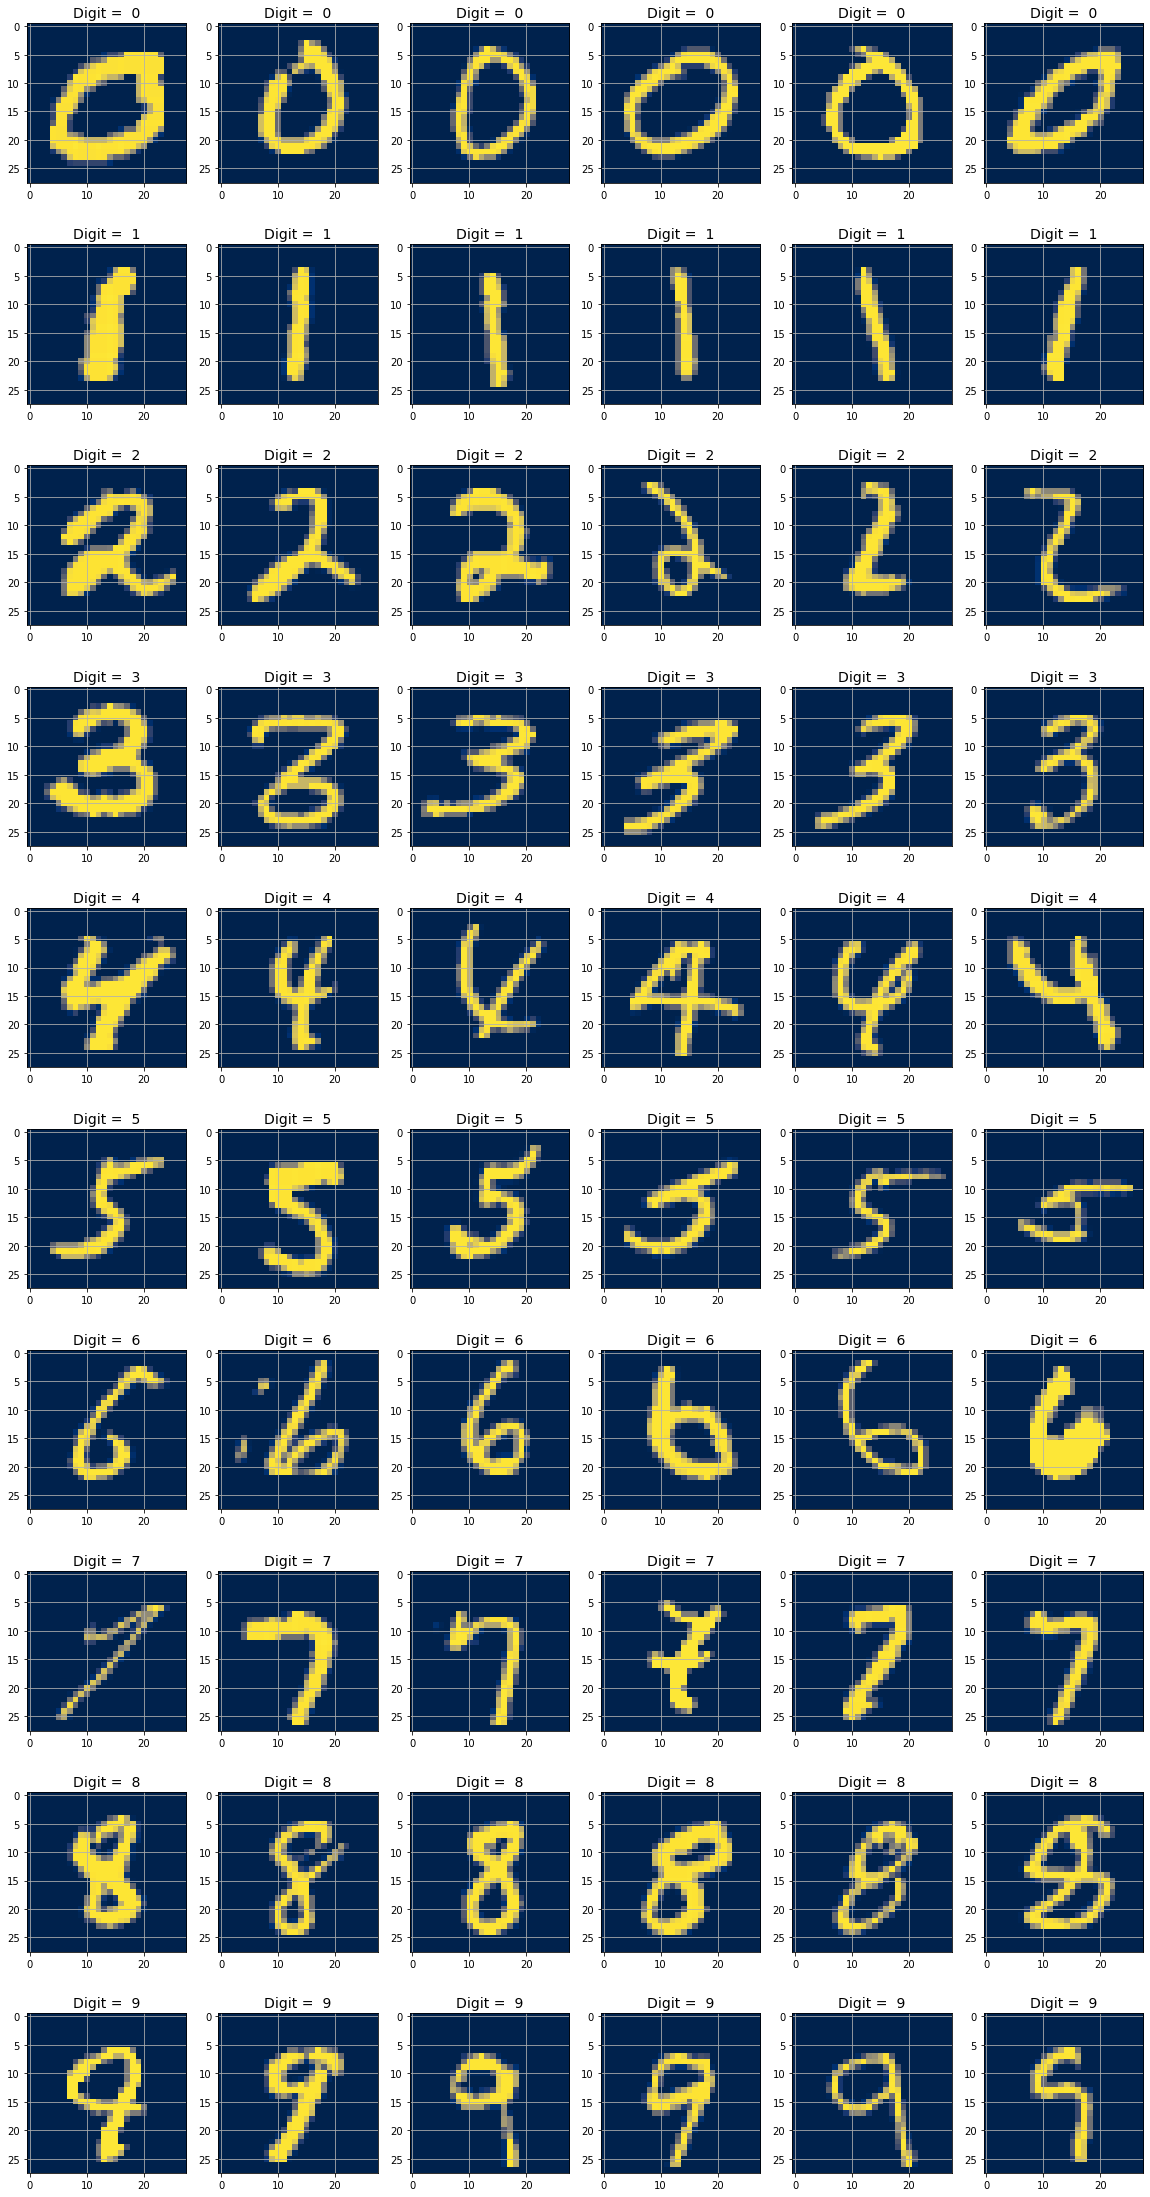

In [ ]:
fig, axes = plt.subplots(nrows=10,ncols=6, figsize=(20,40),sharey=True, sharex=True)
idx = 0
for i in range(10):
    for j in (train_data[train_data.label==i].sample(n=6).index):
        digit = train_data['label'].loc[j]
        idx += 1
        plt.subplot(10,6,idx)
        plt.imshow(np.array(train_data.iloc[j,1:]).reshape(28,28), cmap='cividis')
        plt.title(f'Digit =  {digit}',fontsize=14)
        plt.grid(None)
plt.show()

#### Distribution/histogram of fields in dataset

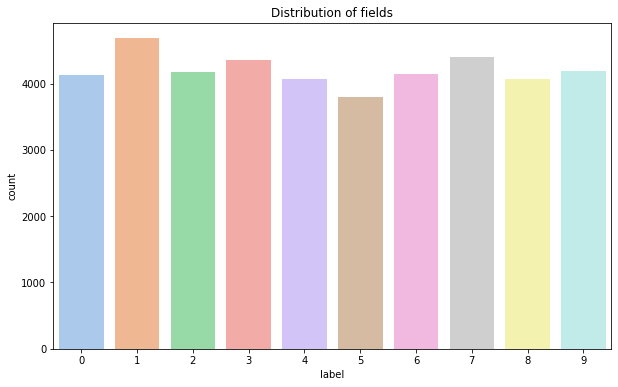

In [ ]:
plt.figure(figsize=(10,6))
plt.title("Distribution of fields")
sns.countplot(data=train_data, x=train_data.label, palette="pastel")


#### Plotting some variables over the other


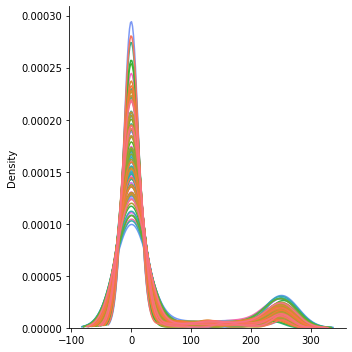

In [ ]:
sns.displot(data=train_data.iloc[:,1:].sample(100).T,kind='kde', legend=False)
plt.show()

It seems that every digit has at least a few small numbers and values greater than 200.

#### Histogram for each field

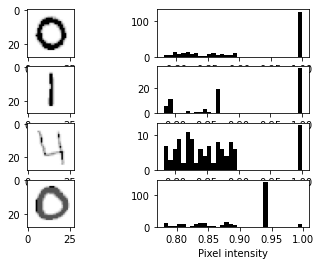

In [ ]:
def histogram(img):
    fig, ax = plt.subplots(nrows = len(img), ncols=2)
    i = 0
    for row in ax:
        row[0].imshow(img[i].reshape(28,28), cmap=plt.cm.Greys)
        
        img_mode = mode(img[i]).mode[0] # leaving out all the values corresponding to zeros
        row[1].hist(list(filter(lambda x: x > img_mode, img[i].ravel())), bins=32, color='black')
        
        i+=1
    
    plt.xlabel('Pixel intensity') 
histogram(exposure.equalize_hist(fields[1:5]))


#### Correlation Analysis

Handling missing values

In [ ]:
correlation=train_data.corr()
correlation.fillna(0)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
label,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.033424,0.025050,0.019558,0.014490,0.009790,0.006075,0.0,0.0,0.0,0.0
pixel0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
pixel1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
pixel2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
pixel3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pixel779,0.006075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.000240,-0.000174,-0.000124,0.236633,0.905835,1.000000,0.0,0.0,0.0,0.0
pixel780,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
pixel781,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
pixel782,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


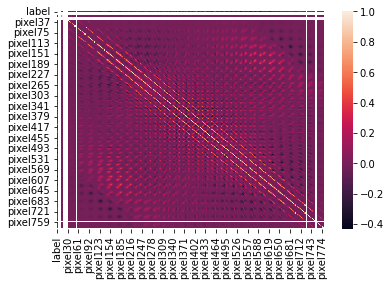

In [ ]:
sns.heatmap(correlation);

#### Principal component analysis

In [ ]:
standardized_data = StandardScaler().fit_transform(train_data)
print(standardized_data.shape)


(42000, 785)


In [ ]:
labels=train_data['label']

#find the co-variance matrix which is : A^T * A
sample_data = standardized_data

# matrix multiplication using numpy
covar_matrix = np.matmul(sample_data.T , sample_data)

print ( "The shape of variance matrix = ", covar_matrix.shape)


The shape of variance matrix =  (785, 785)


Finding the top two eigen-values and corresponding eigen-vectors for projecting onto a 2-Dim space. The parameter 'eigvals' is defined (low value to heigh value) and the eigh function will return the eigen values in asending order

In [ ]:
values, vectors = eigh(covar_matrix, eigvals=(782,783))
print("Shape of eigen vectors = ",vectors.shape)
vectors = vectors.T
print("Updated shape of eigen vectors = ",vectors.shape)
# here the vectors[1] represents the eigen vector corresponding 1st principal eigen vector and vectors[1] represents 
# the eigen vector corresponding 2nd principal eigen vector


Shape of eigen vectors =  (785, 2)
Updated shape of eigen vectors =  (2, 785)


Projecting the original data sample on the plane formed by two principal eigen vectors by vector-vector multiplication.

In [ ]:
new_coordinates = np.matmul(vectors, sample_data.T)

print (" resultanat new data points' shape ", vectors.shape, "X", sample_data.T.shape," = ", new_coordinates.shape)


 resultanat new data points' shape  (2, 785) X (785, 42000)  =  (2, 42000)


In [ ]:
# appending label to the data
new_coordinates = np.vstack((new_coordinates, labels)).T

# creating a new data frame for plotting the labeled points.
dataframe = pd.DataFrame(data=new_coordinates, columns=("1st_principal", "2nd_principal", "label"))
print(dataframe.head())


   1st_principal  2nd_principal  label
0      -3.834079       5.498016    1.0
1      -1.533175      -6.018994    0.0
2      -2.425707       1.959875    1.0
3      -2.284497      -5.716447    4.0
4      -1.153826      -6.049490    0.0


/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


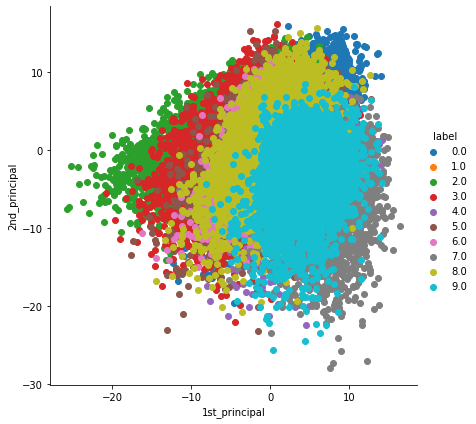

In [ ]:
# ploting the 2d data points
sns.FacetGrid(dataframe, hue="label", size=6).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.show()


Since there is a lot of class overlap, PCA is not particularly effective for the high dimensional dataset. The majority of classrooms are mixed, but very few of them can be. PCA is typically used to reduce dimensionality

#### PCA for Dimension Reduction

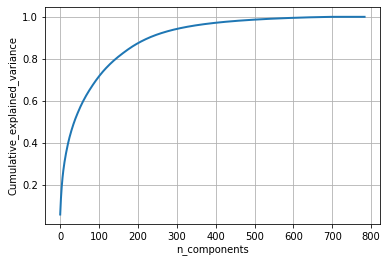

In [ ]:
# initializing the pca
pca = decomposition.PCA()


# PCA for dimensionality redcution (non-visualization)

pca.n_components = 784
pca_data = pca.fit_transform(sample_data)

percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);

cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()


Here we plot the cumulative sum of variance with the component. Here 300 components explain the almost 90% variance. 

#### Feature Selection

In [ ]:
X=train_data.drop('label', axis=1)
y=train_data['label']

imputer=SimpleImputer(strategy='mean')  
imputer.fit(X)


SimpleImputer()

In [ ]:
# implementing train-test-split
X_train, X_test, y_train_full, y_test_full = train_test_split(X, y, test_size=0.20, random_state=66)
#For digit 5, output label=1, for any other digit output label=0
y_train=((y_train_full==5).astype(int))  
y_test=((y_test_full==5).astype(int))


In [ ]:
sm = SMOTE(random_state = 42)
X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=X_train.columns)


In [ ]:

# load X_train and y_train
# NOTE BorutaPy accepts numpy arrays only, if X_train and y_train are pandas dataframes, then add .values attribute X_train.values in that case
X_train_np = X_train.values
y_train_np = y_train.values

# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)

# find all relevant features 
feat_selector.fit(X_train_np, y_train_np)

# check selected features 
feat_selector.support_

# check ranking of features
feat_selector.ranking_

# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(X_train_np)


 

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	784
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	784
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	784
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	784
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	784
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	784
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	784
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	374
Tentative: 	101
Rejected: 	309
Iteration: 	9 / 100
Confirmed: 	374
Tentative: 	101
Rejected: 	309
Iteration: 	10 / 100
Confirmed: 	374
Tentative: 	101
Rejected: 	309
Iteration: 	11 / 100
Confirmed: 	374
Tentative: 	101
Rejected: 	309
Iteration: 	12 / 100
Confirmed: 	378
Tentative: 	97
Rejected: 	309
Iteration: 	13 / 100
Confirmed: 	378
Tentative: 	97
Rejected: 	309
Iteration: 	14 / 100
Confirmed: 	378
Tentative: 	83
Rejected: 	323
Iteration: 	15 / 100
Confirmed: 	378
Tentative: 	83
Rejected: 	323
Iteration: 	16 / 100


In [ ]:
#Getting new X_train column
X_train.columns[feat_selector.support_]


Index(['pixel72', 'pixel97', 'pixel98', 'pixel99', 'pixel100', 'pixel101',
       'pixel102', 'pixel103', 'pixel104', 'pixel124',
       ...
       'pixel684', 'pixel685', 'pixel686', 'pixel687', 'pixel688', 'pixel711',
       'pixel712', 'pixel713', 'pixel740', 'pixel743'],
      dtype='object', length=392)

#### Making the model
Here, the model chosen is a simple CNN Model with conv2D, maxpool2D, flatten and dense layers. The activation function used are RELU and SoftMax.

In [9]:
# Making the CNN Model
model = Sequential()
model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation=tf.nn.relu))
model.add(Dense(10,activation=tf.nn.softmax))

#### Optimizer Evaluation
Evaluating the CNN model against various optimizers such as ADAM, RMSProp, SGD and ADAGRAD

ADAM Optimizer

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99, epsilon=1e-07), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.fit(x=X_train,y=y_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0049 - accuracy: 0.9985
Epoch 2/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0042 - accuracy: 0.9985
Epoch 3/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0043 - accuracy: 0.9984
Epoch 4/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0035 - accuracy: 0.9990
Epoch 5/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0031 - accuracy: 0.9989
Epoch 6/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0027 - accuracy: 0.9991
Epoch 7/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0031 - accuracy: 0.9989
Epoch 8/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0030 - accuracy: 0.9989
Epoch 9/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0024 - accuracy: 0.9992
Epoch 10/10
1875/1875 [==============================] - 12s 7ms/step - l

In [21]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 3ms/step - loss: 0.0769 - accuracy: 0.9824


[0.07685515284538269, 0.9824000000953674]

RMSProp Optimizer

In [23]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.98, momentum=0.0, epsilon=1e-07), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.fit(x=X_train,y=y_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0036 - accuracy: 0.9987
Epoch 2/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0021 - accuracy: 0.9993
Epoch 3/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0023 - accuracy: 0.9992
Epoch 4/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0020 - accuracy: 0.9994
Epoch 5/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0013 - accuracy: 0.9996
Epoch 6/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0013 - accuracy: 0.9997
Epoch 7/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0012 - accuracy: 0.9996
Epoch 8/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0011 - accuracy: 0.9996
Epoch 9/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0013 - accuracy: 0.9996
Epoch 10/10
1875/1875 [==============================] - 15s 8ms/step - l

In [24]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.1005 - accuracy: 0.9850


[0.1005312129855156, 0.9850000143051147]

SGD Optimizer

In [26]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.0), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.fit(x=X_train,y=y_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 14s 7ms/step - loss: 4.3651e-04 - accuracy: 0.9998
Epoch 2/10
1875/1875 [==============================] - 14s 8ms/step - loss: 2.5485e-04 - accuracy: 0.9999
Epoch 3/10
1875/1875 [==============================] - 15s 8ms/step - loss: 1.9069e-04 - accuracy: 0.9999
Epoch 4/10
1875/1875 [==============================] - 15s 8ms/step - loss: 1.5696e-04 - accuracy: 1.0000
Epoch 5/10
1875/1875 [==============================] - 14s 7ms/step - loss: 1.3435e-04 - accuracy: 1.0000
Epoch 6/10
1875/1875 [==============================] - 13s 7ms/step - loss: 1.1881e-04 - accuracy: 1.0000
Epoch 7/10
1875/1875 [==============================] - 13s 7ms/step - loss: 1.0749e-04 - accuracy: 1.0000
Epoch 8/10
1875/1875 [==============================] - 15s 8ms/step - loss: 9.8833e-05 - accuracy: 1.0000
Epoch 9/10
1875/1875 [==============================] - 14s 7ms/step - loss: 9.1983e-05 - accuracy: 1.0000
Epoch 10/10
1875/1875 [==============

In [27]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0980 - accuracy: 0.9856


[0.09796087443828583, 0.9855999946594238]

ADAGRAD Optimizer

In [31]:

model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01, initial_accumulator_value=0.1, epsilon=1e-07), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.fit(x=X_train,y=y_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 14s 7ms/step - loss: 1.3246e-05 - accuracy: 1.0000
Epoch 2/10
1875/1875 [==============================] - 14s 7ms/step - loss: 1.2638e-05 - accuracy: 1.0000
Epoch 3/10
1875/1875 [==============================] - 14s 8ms/step - loss: 1.2104e-05 - accuracy: 1.0000
Epoch 4/10
1875/1875 [==============================] - 14s 7ms/step - loss: 1.1628e-05 - accuracy: 1.0000
Epoch 5/10
1875/1875 [==============================] - 13s 7ms/step - loss: 1.1212e-05 - accuracy: 1.0000
Epoch 6/10
1875/1875 [==============================] - 14s 8ms/step - loss: 1.0830e-05 - accuracy: 1.0000
Epoch 7/10
1875/1875 [==============================] - 17s 9ms/step - loss: 1.0494e-05 - accuracy: 1.0000
Epoch 8/10
1875/1875 [==============================] - 14s 8ms/step - loss: 1.0185e-05 - accuracy: 1.0000
Epoch 9/10
1875/1875 [==============================] - 15s 8ms/step - loss: 9.9354e-06 - accuracy: 1.0000
Epoch 10/10
1875/1875 [==============

In [12]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 4ms/step - loss: 0.1135 - accuracy: 0.9839


[0.11350218206644058, 0.9839000105857849]

#### Result of evaluation

In [3]:
scores_modeles = pd.DataFrame(columns=['Optimizer', 'Accuracy Score'])
scoreDF = pd.DataFrame({'Optimizer': ['ADAM', 'RMSProp', 'SGD', 'ADAGRAD'],'Accuracy Score': [0.982, 0.985, 0.986, 0.984]})
scores_modeles=scores_modeles.append(scoreDF,ignore_index=True)
scores_modeles

,Optimizer,Accuracy Score
0,ADAM,0.982
1,RMSProp,0.985
2,SGD,0.986
3,ADAGRAD,0.984


As we can see from above, the best optimizer for our simple CNN model is SGD with an accuracy of 98.6%. This model will now correctly classify the handwritten number. Below, we take a sample image from the test set - 5.
Our model then evaluates this and correctly classifies it as 5.

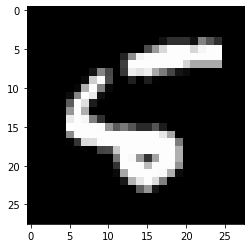

Expected predition value: 5


In [23]:
id = 8

image = np.array(X_test[id], dtype='float')
pixels = image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()
print("Expected predition value:", y_test[id])


Predicted value: 5


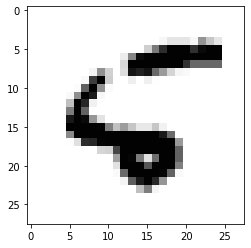

In [21]:

plt.imshow(X_test[id].reshape(28, 28),cmap='Greys')
pred = model.predict(X_test[id].reshape(1, 28, 28, 1))
print("Predicted value:", pred.argmax())